In [ ]:
!pip install gensim

Setup

In [ ]:
import tarfile
import os
import pandas as pd
import numpy as np


import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec

Data Reviews

In [ ]:
def extract_reviews(tar_path, section):
    """
    Extracts reviews from the specified section ('train' or 'test') of the dataset.
    """
    reviews = []
    labels = []

    with tarfile.open(tar_path) as tar:
        for member in tar.getmembers():
            if f'aclImdb/{section}/pos/' in member.name and member.isfile():
                review = tar.extractfile(member).read().decode('utf-8')
                reviews.append(review)
                labels.append(1)  # Positive review
            elif f'aclImdb/{section}/neg/' in member.name and member.isfile():
                review = tar.extractfile(member).read().decode('utf-8')
                reviews.append(review)
                labels.append(0)  # Negative review

    return reviews, labels

# Path to your 'aclImdb_v1.tar.gz' file
tar_path = '/content/aclImdb_v1.tar.gz'

# Extract reviews from both train and test sections
train_reviews, train_labels = extract_reviews(tar_path, 'train')
test_reviews, test_labels = extract_reviews(tar_path, 'test')

# Creating DataFrames
train_df = pd.DataFrame({'review': train_reviews, 'label': train_labels})
test_df = pd.DataFrame({'review': test_reviews, 'label': test_labels})

# Save to CSV files
train_df.to_csv('train_reviews.csv', index=False)
test_df.to_csv('test_reviews.csv', index=False)


In [ ]:
# Merge train and test DataFrames
merged_df = pd.concat([train_df, test_df], ignore_index=True)

# Save to a CSV file
merged_df.to_csv('merged_reviews.csv', index=False)



In [ ]:
print(merged_df.head())

                                              review  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0
2  If only to avoid making this type of film in t...      0
3  This film was probably inspired by Godard's Ma...      0
4  Oh, brother...after hearing about this ridicul...      0


In [ ]:
# 10% only for testing
sampled_df = df.sample(frac=0.1)

# You can optionally reset the index
sampled_df.reset_index(drop=True, inplace=True)

# Save the sampled data to a new CSV file
sampled_df.to_csv('sampled_reviews.csv', index=False)

**Embedding** \\
1. Word2Vec \\
2. Sentence/Document Embeddings \\
3. TF-IDF (Term Frequency-Inverse Document Frequency) \\

Word2Vec

Data Preprocessing

In [ ]:
# Download NLTK stopwords
nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return tokens

# Load the dataset
df = pd.read_csv('sampled_reviews.csv')

# Apply preprocessing
df['processed_reviews'] = df['review'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
print(df['processed_reviews'].head())

0    [lhomme, blesse, impatient, adventureseeking, ...
1    [much, commentary, board, revolves, around, de...
2    [allen, julie, move, cabin, mountains, daughte...
3    [solino, really, moved, deeply, drawn, charact...
4    [cute, little, french, silent, comedy, man, be...
Name: processed_reviews, dtype: object


In [ ]:
# Prepare data for Word2Vec
tokenized_reviews = df['processed_reviews'].tolist()

# Train the Word2Vec model
w2v_model = Word2Vec(tokenized_reviews, vector_size=100, window=5, min_count=2, workers=4)

# Save the model for later use
w2v_model.save("movie_reviews_word2vec.model")

In [ ]:
def vectorize_review(model, tokens):
    vector = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vector, axis=0) if vector else np.zeros(model.vector_size)

# Vectorize a sample review
sample_vector = vectorize_review(w2v_model, df['processed_reviews'][0])

print(sample_vector)

[-3.10994804e-01  4.47235137e-01  3.25036906e-02  1.85752697e-02
  2.11974621e-01 -6.00622177e-01  1.79051220e-01  8.73264074e-01
 -1.66663602e-01 -2.94711530e-01 -2.51506507e-01 -8.17624688e-01
  1.39826965e-02  1.87662885e-01  1.33517921e-01 -3.68874192e-01
  4.03772026e-01 -3.34863454e-01  1.62463352e-01 -1.08488202e+00
  2.71981657e-01  1.50362700e-01  3.63802612e-01 -2.36782715e-01
 -5.24975583e-02  1.06961280e-01 -3.58322442e-01 -2.86926836e-01
 -4.36070383e-01  8.07243958e-02  4.92462963e-01 -7.39654899e-02
 -1.64787229e-02 -3.12667400e-01 -1.22337840e-01  5.89148819e-01
  2.49502473e-02 -1.17280744e-01 -1.84245810e-01 -5.20561635e-01
  2.83077121e-01 -4.57522869e-01 -4.05796200e-01 -4.32472751e-02
  3.26936066e-01 -2.91245818e-01 -2.44273990e-01 -1.39932454e-01
  1.44490123e-01  3.45088333e-01  3.23974639e-01 -1.49232760e-01
 -1.60991192e-01 -1.49007007e-01 -4.47408944e-01  2.43587613e-01
  2.35650226e-01  1.57200024e-01 -4.39633191e-01  2.23029777e-01
  8.59623542e-05 -1.09422

In [ ]:

def sentence_embedding(sentence, model):
    # Ensure the sentence is tokenized
    words = sentence if isinstance(sentence, list) else word_tokenize(sentence)

    # Filter out words not in the model's vocabulary
    words = [word for word in words if word in model.wv]

    if len(words) >= 1:
        return np.mean(model.wv[words], axis=0)
    else:
        # Return a zero vector if sentence has no words in the model's vocabulary
        return np.zeros(model.vector_size)

# Apply sentence embedding to each review
df['sentence_vector'] = df['processed_reviews'].apply(lambda x: sentence_embedding(x, w2v_model))

# Extract the sentence vectors for PCA
sentence_vectors = np.vstack(df['sentence_vector'])


PCA Dimension Reduction

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# Initialize a PCA model for 2 components
pca = PCA(n_components=2)

# Apply PCA to the sentence vectors
sentence_pca = pca.fit_transform(sentence_vectors)

Plotting

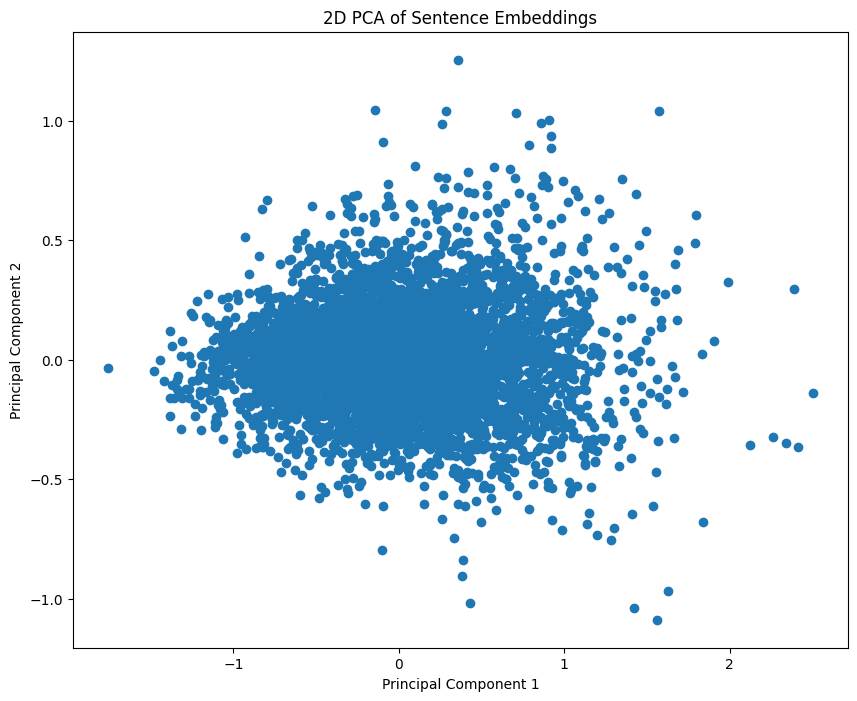

In [ ]:
import matplotlib.pyplot as plt

# Visualizing the first few sentence embeddings
plt.figure(figsize=(10, 8))
plt.scatter(sentence_pca[:, 0], sentence_pca[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA of Sentence Embeddings')
plt.show()